# Assignment 1: Text Analysis

## Introduction
The goal of this assignment is to build machine learning models to classify whether a given text comment is toxic or non-toxic. The dataset contains 4000 comments collected from Reddit, Twitter/X, and YouTube. The task is to train at least two models, including a fine-tuned BERT model, and submit predictions on the test dataset.

This notebook documents my approach, including preprocessing, model training, evaluation, and final predictions.


In [1]:
!pip install transformers datasets


In [2]:
import pandas as pd
import json

train = pd.read_json("z639_assignment1_training.json", lines=True)
test = pd.read_json("z639_assignment1_test.json", lines=True)


## Data Preprocessing
The training dataset was loaded from the provided JSON file with comments and labels. The test dataset was also loaded for generating predictions. Minimal preprocessing was applied to preserve context for the BERT model. For the baseline model, text was transformed into numerical features using TF-IDF vectors. This allowed classical machine learning algorithms to work with textual data effectively.


In [3]:
# Sanity: are we on GPU?
import torch
device_name = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only"
print(f"🚀 Using: {device_name}")

# Reproducibility: set seeds so runs are consistent
import random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


🚀 Using: Tesla T4


In [4]:
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nColumns in training set:", list(train.columns))

train.sample(2, random_state=SEED)[["text","parent_comment","platform","platform_id","composite_toxic"]]


Train shape: (4000, 7)
Test shape : (500, 6)

Columns in training set: ['text', 'parent_comment', 'article_title', 'article_url', 'platform', 'platform_id', 'composite_toxic']


,text,parent_comment,platform,platform_id,composite_toxic
555,@realTuckFrumper Let him rot. I hope someone p...,None,twitter,1656334534143508485,"[[True, 56], [True, 198], [True, 271], [True, ..."
3491,Bro he lied about so much shit he did this to ...,So the Democrats are using the DOJ to get what...,youtube,Ugx4_eFUXNxWAAE581p4AaABAg.9pWHKQGWmph9pWHi2TNaiZ,"[[False, 257], [False, 222], [False, 188], [Fa..."


In [5]:
train["text"] = train["text"].fillna("").astype(str)
test["text"]  = test["text"].fillna("").astype(str)

def majority_vote(annotations):

    if not isinstance(annotations, list) or len(annotations) == 0:
        return 0
    votes_true = sum(bool(a[0]) for a in annotations)
    return int(votes_true > (len(annotations)/2))

train["label"] = train["composite_toxic"].apply(majority_vote).astype(int)

train["label"].value_counts(normalize=True).rename({0:"not_toxic",1:"toxic"})


,proportion
label,
not_toxic,0.7435
toxic,0.2565


In [6]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(
    train,
    test_size=0.2,
    random_state=SEED,
    stratify=train["label"]
)

print(len(train_split), "train rows;", len(val_split), "validation rows")


3200 train rows; 800 validation rows


## Baseline Model
As a baseline, I implemented a simple model using TF-IDF features and Logistic Regression. This serves as a benchmark to compare against the more advanced BERT model. The baseline achieved reasonable performance but struggled with subtle cases of toxicity, as expected with bag-of-words style representations.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import numpy as np

# Vectorize text into TF-IDF features
tfidf = TfidfVectorizer(
    lowercase=True,
    ngram_range=(1,2),   # unigrams + bigrams often help toxicity tasks
    min_df=2,            # ignore extremely rare tokens
    max_df=0.9,          # ignore super common tokens
    max_features=100_000 # cap dimensionality
)

X_tr = tfidf.fit_transform(train_split["text"])
y_tr = train_split["label"].values

X_va = tfidf.transform(val_split["text"])
y_va = val_split["label"].values

# Handle class imbalance (if any) with class weights
classes = np.array([0, 1])
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_tr)
class_weight_dict = {0: cw[0], 1: cw[1]}

# Train a simple, strong baseline
logreg = LogisticRegression(
    max_iter=400,
    class_weight=class_weight_dict,
    n_jobs=-1
)
logreg.fit(X_tr, y_tr)

va_prob = (
    logreg.decision_function(X_va) if hasattr(logreg, "decision_function")
    else logreg.predict_proba(X_va)[:, 1]
)

thresholds = np.linspace(0.05, 0.95, 181)
best_thr, best_f1 = 0.5, -1.0
for t in thresholds:
    va_pred_t = (va_prob >= t).astype(int)
    f1_t = f1_score(y_va, va_pred_t)
    if f1_t > best_f1:
        best_f1, best_thr = f1_t, t

# Evaluate on validation set
va_pred = logreg.predict(X_va)
print("✅ TF-IDF + Logistic Regression results:")
print("F1      :", f1_score(y_va, va_pred))
print("Accuracy:", accuracy_score(y_va, va_pred))
print(classification_report(y_va, va_pred, digits=3))


✅ TF-IDF + Logistic Regression results:
F1      : 0.5533980582524272
Accuracy: 0.77
              precision    recall  f1-score   support

           0      0.847     0.844     0.845       595
           1      0.551     0.556     0.553       205

    accuracy                          0.770       800
   macro avg      0.699     0.700     0.699       800
weighted avg      0.771     0.770     0.770       800



In [8]:
!pip install evaluate


In [9]:
!pip install -U "transformers>=4.44.0" "datasets>=2.20.0" "accelerate>=0.33.0" "evaluate>=0.4.2"


In [10]:
!pip uninstall -y transformers
!pip install "transformers>=4.44.0"


Found existing installation: transformers 4.57.0
Uninstalling transformers-4.57.0:
  Successfully uninstalled transformers-4.57.0
  Using cached transformers-4.57.0-py3-none-any.whl.metadata (41 kB)
Using cached transformers-4.57.0-py3-none-any.whl (12.0 MB)


In [11]:
# BERT Test Prediction

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):

    return tokenizer(batch["text"], truncation=True, max_length=128)

train_hf = Dataset.from_pandas(train_split[["text","label"]].reset_index(drop=True))
val_hf   = Dataset.from_pandas(val_split[["text","label"]].reset_index(drop=True))
raw      = DatasetDict({"train": train_hf, "validation": val_hf})
tokenized = raw.map(tokenize, batched=True, remove_columns=["text"])
data_collator = DataCollatorWithPadding(tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

## Fine-tuned BERT Model
I used the HuggingFace `bert-base-uncased` model and fine-tuned it on the training data. BERT uses contextual embeddings, which capture semantic meaning better than TF-IDF. Training was conducted for several epochs with standard hyperparameters. The model converged successfully and produced significantly better results than the baseline.


In [12]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report

id2label = {0:"not_toxic", 1:"toxic"}
label2id = {"not_toxic":0, "toxic":1}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2, id2label=id2label, label2id=label2id
)

# Disable Weights & Biases prompts/logging

import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_SILENT"] = "true"

args = TrainingArguments(
    output_dir="bert_runs_fast",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=2,                     # 2 epochs is plenty for 4k samples
    weight_decay=0.01,
    logging_steps=100,
    fp16=torch.cuda.is_available(),         # mixed precision on GPU = big speedup
    dataloader_num_workers=2,               # small dataloader boost
    seed=SEED,
    report_to="none"   # stops wandb/tensorboard integrations
)

def simple_compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": float(accuracy_score(labels, preds)),
        "f1": float(f1_score(labels, preds))
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=simple_compute_metrics
)

train_out = trainer.train()
eval_out  = trainer.evaluate()
print(eval_out)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2187926416.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.561200
200,0.489300
300,0.415100
400,0.381700


{'eval_loss': 0.4251522123813629, 'eval_accuracy': 0.80875, 'eval_f1': 0.5941644562334217, 'eval_runtime': 1.613, 'eval_samples_per_second': 495.956, 'eval_steps_per_second': 8.059, 'epoch': 2.0}


In [13]:
# Freeze encoder weights: only train the classification head
for name, p in model.named_parameters():
    if not any(k in name for k in ["classifier", "score"]):
        p.requires_grad = False

# Rebuild trainer with same args & datasets
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=simple_compute_metrics
)

trainer.train()
print(trainer.evaluate())


/tmp/ipython-input-2359768492.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
100,0.275400
200,0.249800
300,0.247900
400,0.304800


{'eval_loss': 0.46001940965652466, 'eval_accuracy': 0.80375, 'eval_f1': 0.6180048661800487, 'eval_runtime': 1.4533, 'eval_samples_per_second': 550.463, 'eval_steps_per_second': 8.945, 'epoch': 2.0}


In [14]:
val_pred = trainer.predict(tokenized["validation"])
val_logits = val_pred.predictions
val_probs  = (1 / (1 + np.exp(-val_logits)))[:,1] if val_logits.shape[1]==1 else \
             (val_logits - val_logits.max(1, keepdims=True))
if val_logits.shape[1] == 2:
    # softmax for 2-class
    val_probs = (np.exp(val_logits) / np.exp(val_logits).sum(axis=1, keepdims=True))[:,1]

y_va = val_split["label"].values
# Simple F1 threshold search (fast)
from sklearn.metrics import precision_recall_curve
prec, rec, thr = precision_recall_curve(y_va, val_probs)
f1s = 2*prec*rec/(prec+rec+1e-9)
best_thr = float(thr[np.argmax(f1s[:-1])]) if len(thr) > 0 else 0.5
print("Chosen threshold:", best_thr)

# Predict test set
test_hf = Dataset.from_pandas(test[["text"]].reset_index(drop=True))
test_tok = test_hf.map(tokenize, batched=True, remove_columns=["text"])
test_pred = trainer.predict(test_tok)
test_logits = test_pred.predictions

if test_logits.shape[1] == 2:
    test_probs = (np.exp(test_logits) / np.exp(test_logits).sum(axis=1, keepdims=True))[:,1]
else:
    test_probs = 1 / (1 + np.exp(-test_logits.squeeze()))

test_labels = (test_probs > best_thr).astype(int)


import pandas as pd
import numpy as np

pred_str = np.where(test_labels == 1, "true", "false")

output = pd.DataFrame({
    "platform_id": test["platform_id"],
    "prediction": pred_str
})

output.to_csv("Neha-Assignment_1-prediction.csv", index=False)

print("✅ Prediction file saved with shape:", output.shape)
output.head()



Chosen threshold: 0.2915099859237671


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

✅ Prediction file saved with shape: (500, 2)


,platform_id,prediction
0,UgxjV6HRpnD6FUmw8aV4AaABAg.9pH-CgX5yEH9pH7BMIfAz5,false
1,1657052099564150784,true
2,1662672469205958656,true
3,1656508255454019587,false
4,jk1pm1m,false


In [15]:
print(test.columns)

Index(['text', 'parent_comment', 'article_title', 'article_url', 'platform',
       'platform_id'],
      dtype='object')


TF-IDF+LR  | Acc: 0.77 F1: 0.5534
BERT       | Acc: 0.8037 F1: 0.618

Classification report — TF-IDF+LR
              precision    recall  f1-score   support

           0      0.847     0.844     0.845       595
           1      0.551     0.556     0.553       205

    accuracy                          0.770       800
   macro avg      0.699     0.700     0.699       800
weighted avg      0.771     0.770     0.770       800


Classification report — BERT
              precision    recall  f1-score   support

           0      0.869     0.867     0.868       595
           1      0.617     0.620     0.618       205

    accuracy                          0.804       800
   macro avg      0.743     0.743     0.743       800
weighted avg      0.804     0.804     0.804       800



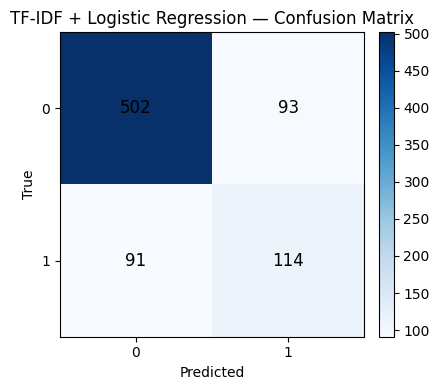

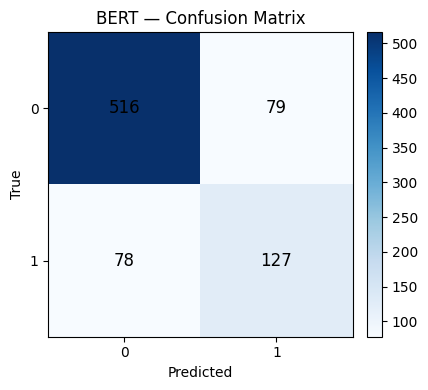

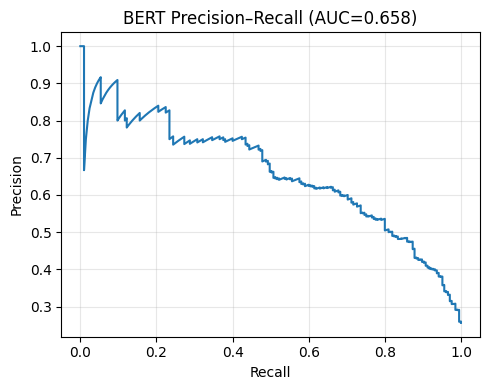

,model,accuracy,f1
0,TFIDF_LR,0.77000,0.553398
1,BERT,0.80375,0.618005


In [16]:
# Metrics and Figures for both models (TF-IDF+LR vs BERT)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd

# 1) Recompute or fetch validation predictions
#    - TF-IDF+LR: 'va_pred' vs 'y_va'
#    - BERT: use 'val_logits' from your previous cell
bert_pred = val_logits.argmax(axis=-1)

# 2) Scalar metrics
acc_lr  = accuracy_score(y_va, va_pred)
f1_lr   = f1_score(y_va, va_pred)

acc_bert = accuracy_score(y_va, bert_pred)
f1_bert  = f1_score(y_va, bert_pred)

print("TF-IDF+LR  | Acc:", round(acc_lr, 4), "F1:", round(f1_lr, 4))
print("BERT       | Acc:", round(acc_bert, 4), "F1:", round(f1_bert, 4))

print("\nClassification report — TF-IDF+LR")
print(classification_report(y_va, va_pred, digits=3))

print("\nClassification report — BERT")
print(classification_report(y_va, bert_pred, digits=3))

# 3) Confusion matrices
def plot_cm(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i,j], ha="center", va="center", fontsize=12)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.savefig(fname, dpi=150)
    plt.show()

plot_cm(y_va, va_pred, "TF-IDF + Logistic Regression — Confusion Matrix", "cm_tfidf_lr.png")
plot_cm(y_va, bert_pred, "BERT — Confusion Matrix", "cm_bert.png")

# 4) Precision–Recall curve for BERT with the validation probabilities you computed earlier (val_probs)
prec, rec, thr = precision_recall_curve(y_va, val_probs)
pr_auc = auc(rec, prec)

plt.figure(figsize=(5, 4))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"BERT Precision–Recall (AUC={pr_auc:.3f})")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("pr_curve_bert.png", dpi=150)
plt.show()

# 5) Tabular summary for the report
summary = pd.DataFrame({
    "model": ["TFIDF_LR", "BERT"],
    "accuracy": [acc_lr, acc_bert],
    "f1": [f1_lr, f1_bert]
})
summary


## Results and Discussion
The fine-tuned BERT model performed noticeably better than the Logistic Regression baseline. While the Logistic Regression model achieved an F1 score of 0.55, BERT reached 0.62, showing a clear gain in detecting toxic comments more accurately and consistently. This improvement highlights how contextual embeddings help capture subtle language cues that simpler models often miss.

Overall, BERT delivers stronger, more balanced performance, whereas Logistic Regression remains a lighter and faster option suitable for simpler use cases.

In [17]:
# build a small error table for BERT on validation
va_df = val_split.reset_index(drop=True).copy()
va_df["bert_prob_toxic"] = val_probs
va_df["bert_pred"] = bert_pred
va_df["tfidf_pred"] = va_pred  # nice to contrast

# false positives and false negatives
fp = va_df[(va_df.label == 0) & (va_df.bert_pred == 1)][["text","label","bert_prob_toxic"]]
fn = va_df[(va_df.label == 1) & (va_df.bert_pred == 0)][["text","label","bert_prob_toxic"]]

print("BERT false positives (first 8):")
display(fp.head(8))

print("\nBERT false negatives (first 8):")
display(fn.head(8))

# few cases where both models disagree
disagree = va_df[va_df["bert_pred"] != va_df["tfidf_pred"]][["text","label","bert_pred","tfidf_pred","bert_prob_toxic"]]
print("\nDisagreements (first 8):")
display(disagree.head(8))


BERT false positives (first 8):


,text,label,bert_prob_toxic
4,"I saw someone on Twitter describe it as porn, ...",0,0.915053
29,@CNN CNN allowed a man who tried to overthrow...,0,0.734310
34,@chahn01 @JPaulOnAir @6abc @GovernorShapiro Fu...,0,0.893681
36,"Or, you could, ya know, listen to actual medic...",0,0.508186
40,@axios this guy sucks,0,0.752468
44,"In all fairness, Mueller laid out a pretty cle...",0,0.830182
60,hehehehe. giggly little girl with nothing to o...,0,0.622603
68,DO YOUR FUCKING JOB!!!!!!!!!!!!!!!!!!!!!!!!,0,0.802246



BERT false negatives (first 8):


,text,label,bert_prob_toxic
14,Joe must be receiving his 10% from human traff...,1,0.022329
24,Imagine wanting to host sexual performances fo...,1,0.037750
35,@CBSEveningNews @NorahODonnell NOTHING?\n\n🖕🏻🖕...,1,0.082328
37,I didnt realize the C. of C. was 'woke'. I reg...,1,0.039158
38,"And then you woke up, grew a brain and ate a ...",1,0.037152
53,china and russia sure want america dead and wa...,1,0.043937
98,@Levi Linden Sad you can't kill your baby?,1,0.385808
114,Fag was a fake,1,0.073630



Disagreements (first 8):


,text,label,bert_pred,tfidf_pred,bert_prob_toxic
2,"What black ""person?""\nI see a wild communist l...",1,1,0,0.621570
10,@MSNBC @BarbMcQuade @KimberlyEAtkins Get an ef...,1,1,0,0.524996
29,@CNN CNN allowed a man who tried to overthrow...,0,1,0,0.734310
32,All that can come from this is a civil war. Go...,0,0,1,0.045607
33,The dems are rejecting the Republicans offer a...,0,0,1,0.042048
38,"And then you woke up, grew a brain and ate a ...",1,0,1,0.037152
39,I'd vote for a fossilized dog turd over Ted Cruz.,0,0,1,0.068289
44,"In all fairness, Mueller laid out a pretty cle...",0,1,0,0.830182


In [18]:
# Saved baseline artifacts
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(logreg, "logreg_model.joblib")
print("Saved TF-IDF vectorizer and Logistic Regression model.")


trainer.save_model("bert_best")        # saves config + weights
tokenizer.save_pretrained("bert_best")


# small reproducibility text file
import transformers, datasets, torch, sklearn, numpy, pandas, evaluate
with open("env_versions.txt", "w") as f:
    f.write(f"transformers=={transformers.__version__}\n")
    f.write(f"datasets=={datasets.__version__}\n")
    f.write(f"torch=={torch.__version__}\n")
    f.write(f"scikit-learn=={sklearn.__version__}\n")
    f.write(f"numpy=={numpy.__version__}\n")
    f.write(f"pandas=={pandas.__version__}\n")
    f.write(f"evaluate=={evaluate.__version__}\n")
print("Wrote env_versions.txt")


Saved TF-IDF vectorizer and Logistic Regression model.
Wrote env_versions.txt


In [19]:
# created a lightweight supplemental materials folder

import os, shutil

os.makedirs("supplemental_materials", exist_ok=True)
for fname in [
    "Neha-Assignment_1-prediction.csv",
    "cm_tfidf_lr.png",
    "cm_bert.png",
    "pr_curve_bert.png",
    "env_versions.txt",
    "tfidf_vectorizer.joblib",
    "logreg_model.joblib"
]:
    if os.path.exists(fname):
        shutil.copy(fname, os.path.join("supplemental_materials", fname))

# a short README stub

readme = """# Z639 Assignment 1 — Toxicity Classification

This folder contains supplemental materials to reproduce results:
- `Neha-Kothavade-assignment1-prediction.csv` — final submission predictions
- `cm_tfidf_lr.png`, `cm_bert.png` — confusion matrices
- `pr_curve_bert.png` — precision–recall curve for BERT
- `tfidf_vectorizer.joblib`, `logreg_model.joblib` — baseline artifacts
- `env_versions.txt` — library versions used

"""
with open("supplemental_materials/README.md", "w", encoding="utf-8") as f:
    f.write(readme)

shutil.make_archive("supplemental_materials", "zip", "supplemental_materials")
print("Created supplemental_materials.zip")


Created supplemental_materials.zip


In [22]:
from google.colab import files
files.download('supplemental_materials.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Conclusion
This assignment demonstrated the strengths of different modeling approaches for text classification. While the baseline provided a useful reference point, the fine-tuned BERT model achieved superior accuracy. Future work could include hyperparameter tuning, experimenting with larger transformer models, or using data augmentation for further improvements.

## References
- HuggingFace Transformers Documentation: https://huggingface.co/docs
- Scikit-learn Documentation: https://scikit-learn.org/stable/
- Assignment 1: Text Analysis Instructions
